In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import control as ctrl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg as la
import vibrationtesting as vt

Considers a system 

$$\ddot{x} + 2 \dot{x} + 100 x = f(t)$$
with a displacement sensor. 

The state space representation is 

$$\dot{\mathbf{z}} = A \mathbf{z} + B u$$

$$y = C \mathbf{z} + D u$$ 

where 

$$A = 
\begin{bmatrix}
0&1\\
-100&-2
\end{bmatrix}
,\quad
B = 
\begin{bmatrix}0\\1\end{bmatrix}
,\quad
C = \begin{bmatrix}1&0\end{bmatrix}
, \text{ and }
D = [0]$$

In [2]:
sample_freq = 1e3
A = sp.array([[0, 1],\
              [-100, 2]])
B = sp.array([[0], [1]])
C = sp.array([[1, 0]])
D = sp.array([[0]])
sys = ctrl.ss(A, B, C, D)


For this example, we will generate an impulse response for only 4 discrete times.

In [3]:
t = sp.linspace(0, 1, num = 6, endpoint = False)
dt = t[1]
t

array([ 0.        ,  0.16666667,  0.33333333,  0.5       ,  0.66666667,
        0.83333333])

The impulse response for a second order underdamped system is known to be

$$h(t) = \frac{1}{\omega_d}e^{-\zeta \omega_n t}\sin\left(\omega_d t\right)$$

In [4]:
omega_n = sp.sqrt(100)
zeta = 2/(2*omega_n)
omega_d = omega_n * sp.sqrt(1 - zeta**2)

In [5]:
h = 1/omega_d * sp.exp(-zeta*omega_n*t)*sp.sin(omega_d*t)
h

array([ 0.        ,  0.08474903, -0.01254052, -0.05886968,  0.01769677,
        0.03956333])

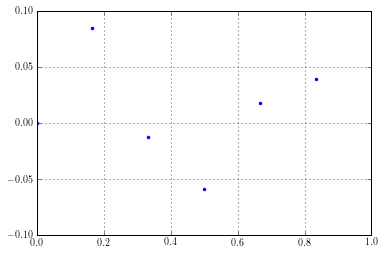

In [6]:
plt.plot(t,h,'.')
plt.axis([0,1,-0.1,0.1])
plt.grid()

In [7]:
Hankel_0 = sp.vstack((h[0:-2],h[1:-1]))
Hankel_0 = Hankel_0.T
Hankel_0

array([[ 0.        ,  0.08474903],
       [ 0.08474903, -0.01254052],
       [-0.01254052, -0.05886968],
       [-0.05886968,  0.01769677]])

In [8]:
h[1:-1]

array([ 0.08474903, -0.01254052, -0.05886968,  0.01769677])

In [9]:
h[2:]

array([-0.01254052, -0.05886968,  0.01769677,  0.03956333])

In [10]:
Hankel_1 = sp.vstack((h[1:-1],h[2:]))
Hankel_1 = Hankel_1.T
Hankel_1

array([[ 0.08474903, -0.01254052],
       [-0.01254052, -0.05886968],
       [-0.05886968,  0.01769677],
       [ 0.01769677,  0.03956333]])

In [11]:
U, sig, Vt = la.svd(Hankel_0)
V = Vt.T
U = U[:,:2]
print(U)
V = V[:,:2]
print(V)

[[ 0.56941225  0.57615451]
 [-0.59214005  0.56070011]
 [-0.32038129 -0.49580091]
 [ 0.47169449 -0.32839431]]
[[-0.66563569  0.74627684]
 [ 0.74627684  0.66563569]]


In [12]:
sig = sp.diag(sig)
print(sig)

[[ 0.11107284  0.        ]
 [ 0.          0.0979112 ]]


In [13]:
A_d = la.inv(sp.sqrt(sig))@U.T@Hankel_1@V@la.inv(sp.sqrt(sig))
print(A_d)

[[-0.22322281  0.85303151]
 [-0.85967388  0.07525037]]


In [14]:
lam_d, vec = la.eig(A_d)
print(lam_d)
print(vec)

[-0.07398622+0.84324217j -0.07398622-0.84324217j]
[[ 0.12298924-0.69493489j  0.12298924+0.69493489j]
 [ 0.70847664+0.j          0.70847664-0.j        ]]


In [15]:
# This should be the same as A_d
print(A_d)
print(vec@sp.diag(lam_d)@la.inv(vec))

[[-0.22322281  0.85303151]
 [-0.85967388  0.07525037]]
[[-0.22322281 -5.55111512e-17j  0.85303151 +1.38777878e-17j]
 [-0.85967388 +6.93889390e-18j  0.07525037 +0.00000000e+00j]]


In [16]:
lam = sp.log(lam_d)/dt
lam

array([-1.+9.94987437j, -1.-9.94987437j])

In [33]:
# These are the continuous time eigenvalues
print('The undamped natural frequency is {} rad/sec.'.format(abs(lam[0])))
print('The damping ratio is {}.'.format(-sp.real(lam[0])/abs(lam[0])))


The undamped natural frequency is 10.0 rad/sec.
The damping ratio is 0.09999999999999998.


The identified state matrix is

In [18]:
A = la.logm(A_d)/dt
print(A)

[[ -2.76092394  10.06538424]
 [-10.1437611    0.76092394]]


which is the system the result in a balanced realization form. 

In [19]:
# The discrete input matrix is
B_d = sp.sqrt(sig)@V.T[:,0].T.reshape((2,1))
print(B_d)

[[-0.22184035]
 [ 0.23351573]]


In [20]:
# The continuous input matrix is
B = la.solve((A_d - sp.eye(2)), A) @ B_d
print(B)

[[-2.58036274]
 [-0.22677789]]


In [21]:
C = (U @ sp.sqrt(sig))[0,:]
print(C)

[ 0.18977139  0.18028315]


In [22]:
# Of course, D is
D = h[0]
D

0.0

# New functions available

In [23]:
vt.d2c(A_d, B_d, C, D, dt)

(array([[ -2.76092394,  10.06538424],
        [-10.1437611 ,   0.76092394]]), array([[-2.58036274],
        [-0.22677789]]), array([ 0.18977139,  0.18028315]), 0.0)

In [24]:
C = sp.array([[1, 0]])

In [25]:
C.shape

(1, 2)

In [26]:
A.shape

(2, 2)

In [27]:
ctrl.ss(A, B, C, D)

A = [[ -2.76092394  10.06538424]
 [-10.1437611    0.76092394]]

B = [[-2.58036274]
 [-0.22677789]]

C = [[1 0]]

D = [[ 0.]]

In [28]:
A.shape

(2, 2)

In [29]:
C.shape

(1, 2)

In [30]:
sys = ctrl.ss(A, B, C, D)

In [31]:
sys

A = [[ -2.76092394  10.06538424]
 [-10.1437611    0.76092394]]

B = [[-2.58036274]
 [-0.22677789]]

C = [[1 0]]

D = [[ 0.]]

In [32]:
sysd = sig.cont2discrete((A, B, C, D),dt)
sysd

AttributeError: 'numpy.ndarray' object has no attribute 'cont2discrete'

In [ ]:
Ad, Bd, _, _ = vt.c2d(A, B, C, D, dt)
print(Ad)
print(Bd)

In [ ]:
vt.damp(A)

In [ ]:
(A_d*dt)@B

In [ ]:
la.expm(sp.hstack((A, B))*dt)